# Gaussian input/output treatments

## using pymatgen library

Germain Salvato Vallverdu, March 23, 2023

### import used modules and objects

Load some pymatgen specific classes and module

In [1]:
from pymatgen.core import Molecule, Site
from pymatgen.io.gaussian import GaussianInput, GaussianOutput

Image class of IPython for rendering pictures.

In [2]:
from IPython.display import Image

### Generate gaussian inputs

Hereafter is the docstring of the ```GaussianInput``` class.

In [3]:
help(GaussianInput)

Help on class GaussianInput in module pymatgen.io.gaussian:

class GaussianInput(builtins.object)
 |  GaussianInput(mol, charge=None, spin_multiplicity=None, title=None, functional='HF', basis_set='6-31G(d)', route_parameters=None, input_parameters=None, link0_parameters=None, dieze_tag='#P', gen_basis=None)
 |  
 |  An object representing a Gaussian input file.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, mol, charge=None, spin_multiplicity=None, title=None, functional='HF', basis_set='6-31G(d)', route_parameters=None, input_parameters=None, link0_parameters=None, dieze_tag='#P', gen_basis=None)
 |      Args:
 |          mol: Input molecule. It can either be a Molecule object,
 |              a string giving the geometry in a format supported by Gaussian,
 |              or ``None``. If the molecule is ``None``, you will need to use
 |              read it in from a checkpoint. Consider adding ``CHK`` to the
 |              ``link0_parameters``.
 |          charge: Charge of

#### Examples

In this example, we get a $PO_2N^{2-}$ molecule and look for the best place for two Li atoms in the plane of the molecule. This example shows how to set up a Gaussian input file for all possible combinations. Coordinates of this molecule are available in xyz format :

4
P1 N1 O2
P -2.714301 0.000003 0.056765
O -1.926896 -1.284476 0.128633
O -1.925428 1.283516 0.129485
N -4.181288 0.000879 -0.079861


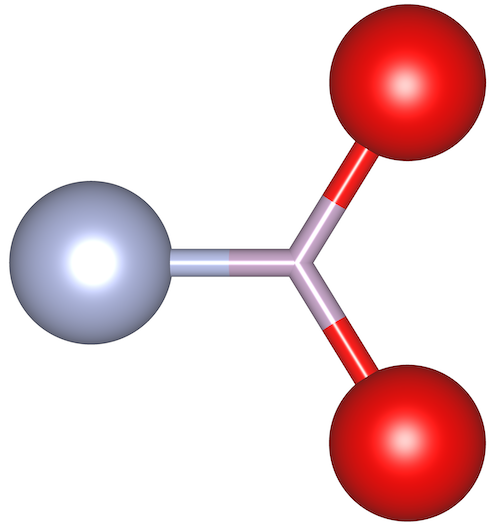

In [4]:
mol = Molecule.from_file("data_nglview/PO2N.xyz")
print(mol.to(fmt="xyz"))
Image("data_nglview/PO2N.png")

First we set up the three guessed positions for Li atoms in the plane of the molecule. Each position is along the bissector of two PO or PN bonds. We build a list of ```pymatgen.Site``` object which represent an atom with its symbol, coordinates ....

In [5]:
posLi = [Site("Li", [-0.424, -0.001,  0.267]),
         Site("Li", [-3.789, -2.031, -0.046]),
         Site("Li", [-3.787,  2.032, -0.044])]
print(posLi)

[Site: Li (-0.4240, -0.0010, 0.2670), Site: Li (-3.7890, -2.0310, -0.0460), Site: Li (-3.7870, 2.0320, -0.0440)]


Now for each combinaison of two Li atoms among three possibilities we will write a gaussian input file. Look at the ```combinations``` method of ```itertools``` module.

In [6]:
from itertools import combinations

In [7]:
for sites in combinations(posLi, 2):
    print(sites, "\t indices : ", [posLi.index(site) for site in sites])

(Site: Li (-0.4240, -0.0010, 0.2670), Site: Li (-3.7890, -2.0310, -0.0460)) 	 indices :  [0, 1]
(Site: Li (-0.4240, -0.0010, 0.2670), Site: Li (-3.7870, 2.0320, -0.0440)) 	 indices :  [0, 2]
(Site: Li (-3.7890, -2.0310, -0.0460), Site: Li (-3.7870, 2.0320, -0.0440)) 	 indices :  [1, 2]


Hereafter is the loop over combinations which will write all input files.

In [8]:
# Gaussian keywords
route_parms = {"opt": "tight", "Freq": ""}
link0 = {"%Nproc": "5"}
DFT = "B3LYP"

# the loop
for sites in combinations(posLi, 2):
    # load the molecule
    mol = Molecule.from_file("data_nglview/PO2N.xyz")
    
    # set up a label according to the combination
    title = "combination_" + "".join([str(posLi.index(site)) for site in sites])
    print(title)
    
    # add the two Li atoms to the molecule
    for site in sites:
        mol.append(site.specie, site.coords)
        
    # set up the calculation
    gau = GaussianInput(mol, charge=0, spin_multiplicity=1, title=title, 
                        functional=DFT, route_parameters=route_parms, link0_parameters=link0)
    gau.write_file(title + ".com", cart_coords=True)

combination_01
combination_02
combination_12


We can also load an input file and get some information.

In [9]:
gau = GaussianInput.from_file("combination_01.com")
print(gau.basis_set, gau.functional)

6-31G(d) B3LYP


In [10]:
print(gau.to_string(cart_coords=True))

%Nproc=5
#P B3LYP/6-31G(d) Freq opt=tight

combination_01

0 1
P -2.714301 0.000003 0.056765
O -1.926896 -1.284476 0.128633
O -1.925428 1.283516 0.129485
N -4.181288 0.000879 -0.079861
Li -0.424000 -0.001000 0.267000
Li -3.789000 -2.031000 -0.046000






### Post-treatments of Gaussian outputs

#### Docstring of the ```GaussianOutput``` class

In [11]:
help(GaussianOutput)

Help on class GaussianOutput in module pymatgen.io.gaussian:

class GaussianOutput(builtins.object)
 |  GaussianOutput(filename)
 |  
 |  Parser for Gaussian output files.
 |  
 |  .. note::
 |  
 |      Still in early beta.
 |  
 |  Attributes:
 |  .. attribute:: structures
 |  
 |      All structures from the calculation in the standard orientation. If the
 |      symmetry is not considered, the standard orientation is not printed out
 |      and the input orientation is used instead. Check the `standard_orientation`
 |      attribute.
 |  
 |  .. attribute:: structures_input_orientation
 |  
 |      All structures from the calculation in the input orientation or the
 |      Z-matrix orientation (if an opt=z-matrix was requested).
 |  
 |  .. attribute:: opt_structures
 |  
 |      All optimized structures from the calculation in the standard orientation,
 |      if the attribute 'standard_orientation' is True, otherwise in the input
 |      or the Z-matrix orientation.
 |  
 |  .. a

#### Examples :

Used the ```GaussianOutput``` class to read a Gaussian output file.

In [12]:
logfile = GaussianOutput("data_nglview/config_0123.log")

Is termination ```Normal``` ?

In [13]:
logfile.properly_terminated

True

Display final energy or mulliken charges :

In [14]:
logfile.final_energy

-1239.01264675

In [15]:
logfile.Mulliken_charges

{1: ['P', 1.751758],
 2: ['P', 1.203271],
 3: ['O', -0.722993],
 4: ['O', -0.771242],
 5: ['O', -0.804145],
 6: ['O', -0.771148],
 7: ['O', -0.633752],
 8: ['O', -0.633729],
 9: ['O', -0.519418],
 10: ['Li', 0.528585],
 11: ['Li', 0.528596],
 12: ['Li', 0.421974],
 13: ['Li', 0.422242]}

You can extract the coordinates of the final structure. All structures are ```pymatgen.Molecule``` objects, see [here](http://pymatgen.org/_static/Molecule.html) or [the reference guide](http://pymatgen.org/pymatgen.core.html#pymatgen.core.structure.Molecule). You can do lot of stuff with this object such as : neighbors list, compute distances or the distance matrix, symmetry operation, atomic substitution ...

In [16]:
print(logfile.final_structure.to(fmt="xyz"))

13
Li4 P2 O7
P 1.803152 -0.000062 -0.074603
P -2.714301 0.000003 0.056765
O 0.711492 0.000020 -1.166577
O 1.626159 1.347642 0.712312
O 3.338973 -0.000234 -0.476901
O 1.625851 -1.347548 0.712612
O -1.926896 -1.284476 0.128633
O -1.925428 1.283516 0.129485
O -4.181288 0.000879 -0.079861
Li 3.387513 1.698635 0.310029
Li 3.387174 -1.698958 0.310641
Li -0.135176 -1.487921 -0.211882
Li -0.134065 1.489076 -0.212137


You would prefer a gaussian input format with a z-matrix of the 42th geometrical optimization step.

In [17]:
print(logfile.structures[41].to(fmt="gjf"))

#P HF/6-31G(d) 

Li4 P2 O7

0 1
P
P 1 B1
O 1 B2 2 A2
O 1 B3 3 A3 2 D3
O 1 B4 4 A4 3 D4
O 1 B5 5 A5 3 D5
O 2 B6 3 A6 6 D6
O 2 B7 7 A7 3 D7
O 2 B8 7 A8 8 D8
Li 4 B9 5 A9 1 D9
Li 6 B10 5 A10 1 D10
Li 7 B11 3 A11 6 D11
Li 8 B12 4 A12 3 D12

B1=4.376288
B2=1.543372
A2=36.067295
B3=1.572484
A3=105.757762
D3=-63.587256
B4=1.587877
A4=103.530048
D4=127.302261
B5=1.570339
A5=103.613837
D5=118.342854
B6=1.509599
A6=70.094274
D6=-30.800762
B7=1.509898
A7=116.635764
D7=-54.758827
B8=1.474749
A8=121.618553
D8=-179.642556
B9=1.844669
A9=48.464768
D9=-173.301681
B10=1.844418
A10=48.529403
D10=176.422774
B11=1.836204
A11=36.882001
D11=-26.625480
B12=1.836768
A12=14.624477
D12=-64.000507






You can plot the geometrical convergence (here using plotly).

In [19]:
import plotly.graph_objs as go

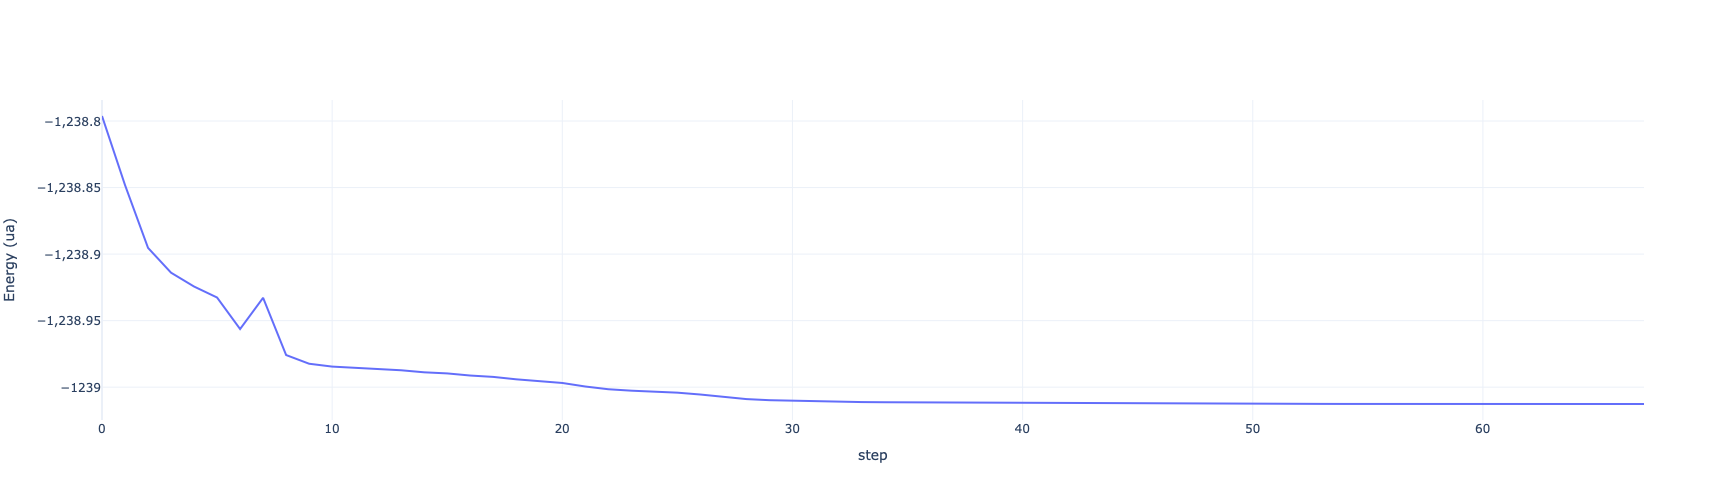

In [28]:
fig = go.Figure([
    go.Scatter(x=[i for i in range(len(logfile.energies))], y=logfile.energies)
],
    layout=go.Layout(
        xaxis=dict(title="step"), 
        yaxis=dict(title="Energy (ua)"),
        template="plotly_white",
        height=500,
    )
)
fig.show()

In [29]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Energy (ua)')

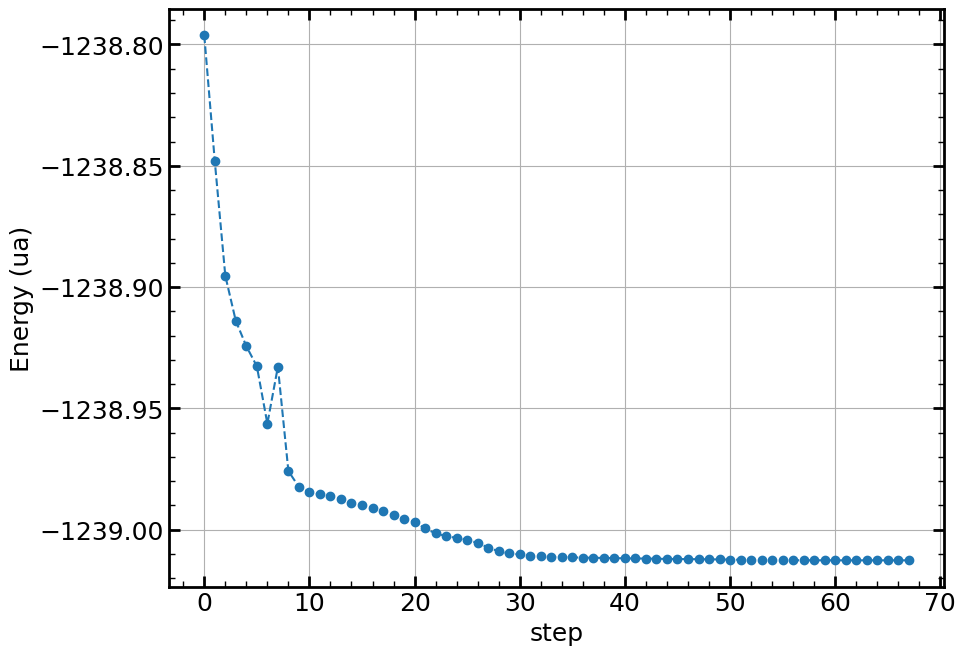

In [33]:
plt.plot(logfile.energies, "o--")
plt.xlabel("step")
plt.ylabel("Energy (ua)")